In [1]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 6.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
# Pytorch package
import torch
import torch.nn as nn


from torchmetrics.regression import MeanAbsolutePercentageError

In [3]:
df = pd.read_csv("cgm_data.csv")
for column in df.columns:
    df[column] = df[column].astype(float)
df.rename({0:"ID"}, axis=1)
df = df.drop("ptid", axis=1)
df = df.iloc[:-1 , :]
df

,0 days 00:00:00,0 days 00:15:00,0 days 00:30:00,0 days 00:45:00,0 days 01:00:00,0 days 01:15:00,0 days 01:30:00,0 days 01:45:00,0 days 02:00:00,0 days 02:15:00,...,4 days 21:30:00,4 days 21:45:00,4 days 22:00:00,4 days 22:15:00,4 days 22:30:00,4 days 22:45:00,4 days 23:00:00,4 days 23:15:00,4 days 23:30:00,4 days 23:45:00
0,138.6,120.6,106.2,97.2,88.2,75.6,64.8,59.4,59.4,68.4,...,104.4,97.2,93.6,90.0,93.6,104.4,108.0,106.2,104.4,108.0
1,102.6,97.2,95.4,91.8,86.4,82.8,86.4,90.0,88.2,84.6,...,145.8,151.2,149.4,145.8,145.8,142.2,136.8,127.8,126.0,127.8
2,151.2,145.8,142.2,142.2,142.2,149.4,156.6,151.2,145.8,142.2,...,151.2,149.4,154.8,172.8,190.8,203.4,212.4,217.8,219.6,208.8
3,257.4,246.6,235.8,225.0,228.6,255.6,289.8,311.4,313.2,311.4,...,226.8,207.0,198.0,190.8,169.2,145.8,124.2,102.6,84.6,70.2
4,264.6,262.8,248.4,241.2,241.2,237.6,232.2,232.2,235.8,235.8,...,171.0,174.6,174.6,178.2,180.0,181.8,181.8,181.8,185.4,190.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,194.4,212.4,210.6,180.0,149.4,133.2,122.4,109.8,109.8,124.2,...,192.6,183.6,176.4,169.2,156.6,131.4,115.2,113.4,113.4,100.8
92,86.4,73.8,63.0,55.8,46.8,43.2,45.0,43.2,43.2,46.8,...,264.6,286.2,298.8,291.6,279.0,264.6,252.0,244.8,232.2,219.6
93,147.6,140.4,136.8,133.2,131.4,122.4,111.6,106.2,97.2,82.8,...,201.6,190.8,181.8,165.6,151.2,149.4,147.6,144.0,142.2,131.4
94,136.8,147.6,160.2,176.4,198.0,205.2,205.2,219.6,235.8,244.8,...,194.4,199.8,219.6,235.8,230.4,214.2,205.2,194.4,185.4,180.0


In [4]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [91]:
# Define constants
N_EPOCHS = 1000
NHEAD = 1
NHID = 64
NLAYERS = 2
LR = 0.01
training_patients = 90
prediction_horizon = 1
timestep = 1

In [92]:
# Define the transformer model
class TransformerModel(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super(TransformerModel, self).__init__()
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward), num_layers)
        self.linear = nn.Linear(d_model, 1)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        mask = self.generate_square_subsequent_mask(x.size(0)).to(x.device)
        x = self.transformer_encoder(x, mask)
        x = self.linear(x)
        return x

# Function to split the data
def train_test_split(df, training_patients, prediction_horizon, device):
    train_input = torch.from_numpy(df.iloc[:training_patients,:-prediction_horizon].values).float().to(device)
    train_target = torch.from_numpy(df.iloc[:training_patients, prediction_horizon:].values).float().to(device)
    test_input = torch.from_numpy(df.iloc[training_patients:,:-prediction_horizon].values).float().to(device)
    test_target = torch.from_numpy(df.iloc[training_patients:, prediction_horizon:].values).float().to(device)

    train_input = torch.unsqueeze(train_input, -1).permute(1, 0, 2)
    train_target = torch.unsqueeze(train_target, -1).permute(1, 0, 2)
    test_input = torch.unsqueeze(test_input, -1).permute(1, 0, 2)
    test_target = torch.unsqueeze(test_target, -1).permute(1, 0, 2)
    return train_input, train_target, test_input, test_target

In [ ]:
train_input, train_target, test_input, test_target = train_test_split(df, training_patients, prediction_horizon, device)
print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_target.shape)

# Initialize the model
model = TransformerModel(d_model=1, nhead=NHEAD, num_layers=NLAYERS, dim_feedforward=NHID).to(device)
criterion = MeanAbsolutePercentageError().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []
test_losses = []
avg_test_losses = []
all_test_outputs = torch.zeros(test_input.shape).to(device)


for epoch in range(N_EPOCHS):
    model.train()
    for t in range(timestep, train_input.shape[0]):  # Loop over the time steps in each epoch
        optimizer.zero_grad()
        output = model(train_input[:t]).squeeze(-1)
        loss = criterion(output[:, -1], train_target[:t, -timestep].squeeze(-1))
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'At epoch {epoch}, Training Loss {loss.item()}')


    model.eval()
    with torch.no_grad():
        test_losses = []  # Collect test losses at each time step
        for t in range(timestep, test_input.shape[0]):
            test_output = model(test_input[:t]).squeeze(-1)
            all_test_outputs[:t, :] = test_output.unsqueeze(-1)  # Adjust dimensions here
            test_loss = criterion(test_output[:, -1], test_target[:t, -timestep].squeeze(-1))
            test_losses.append(test_loss.item())
        avg_test_loss = np.mean(test_losses)
        avg_test_losses.append(avg_test_loss)

    if epoch % 10 == 0:
        print(f'Test Loss at epoch {epoch} is {avg_test_loss}')


torch.Size([479, 90, 1])
torch.Size([479, 90, 1])
torch.Size([479, 6, 1])
torch.Size([479, 6, 1])
At epoch 0, Training Loss 0.48981180787086487
Test Loss at epoch 0 is 0.6243958947050022
At epoch 10, Training Loss 0.24449419975280762
Test Loss at epoch 10 is 0.3310729570717991
At epoch 20, Training Loss 0.24448825418949127
Test Loss at epoch 20 is 0.33101139647816014


In [ ]:
torch.save(model, "simpletransformer")

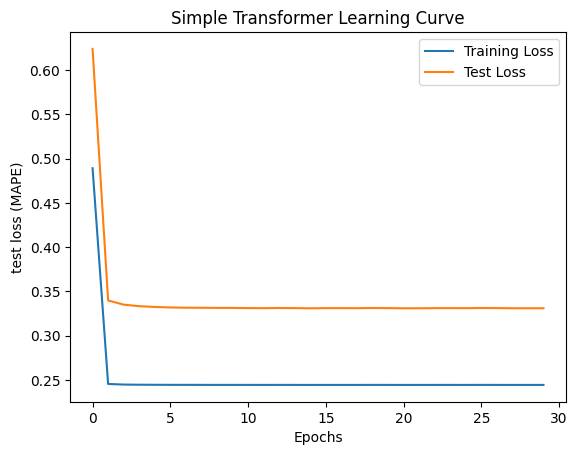

0.3210129141807556


In [79]:
plt.figure()
plt.plot(range(N_EPOCHS), train_losses, label = "Training Loss")
plt.plot(range(N_EPOCHS), avg_test_losses, label = "Test Loss")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Epochs")
plt.title("Simple Transformer Learning Curve")
plt.legend()
plt.show()
print(test_losses[-1])

torch.Size([479, 6, 1])
torch.Size([479, 6, 1])


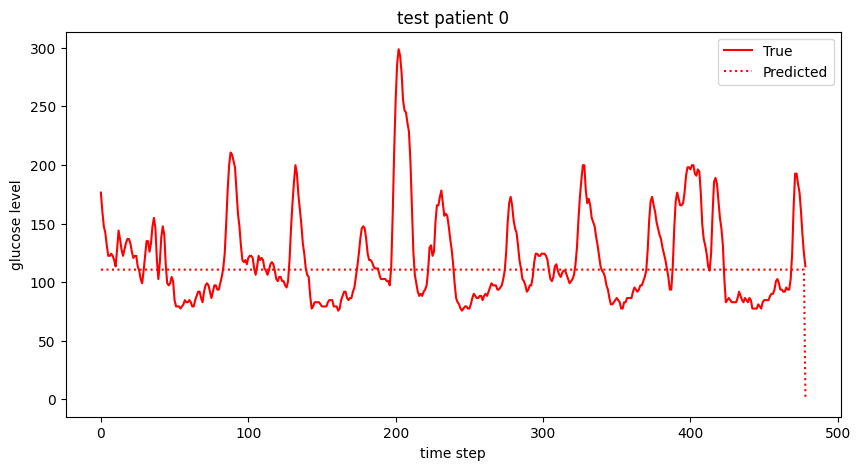

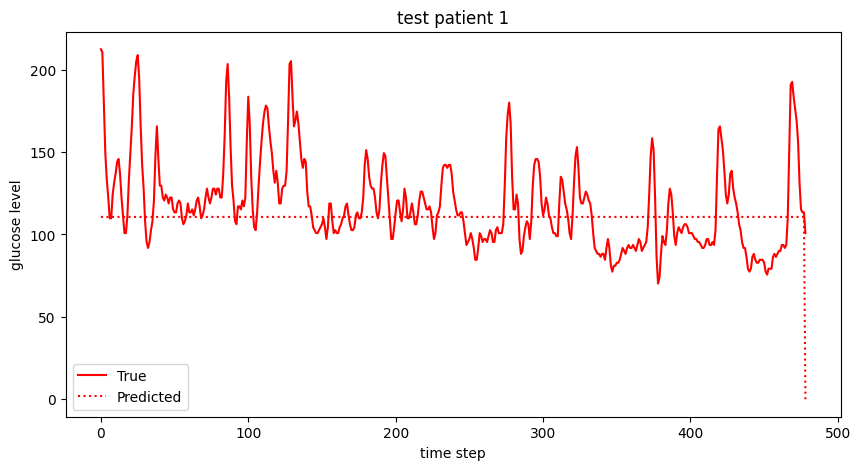

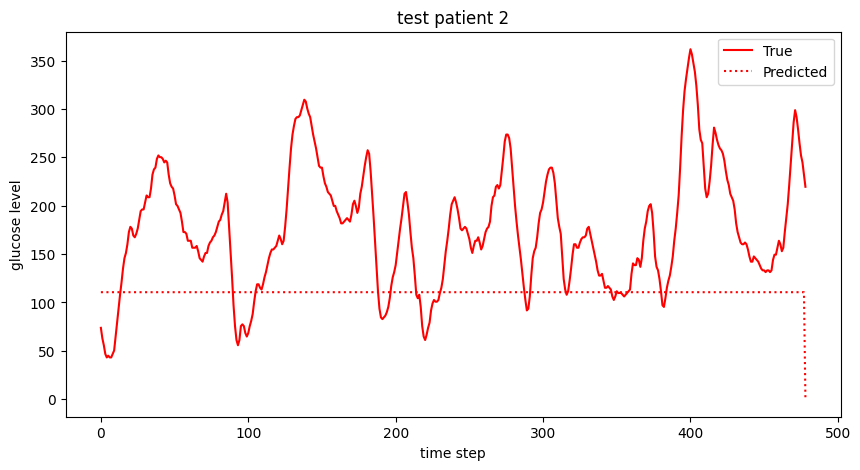

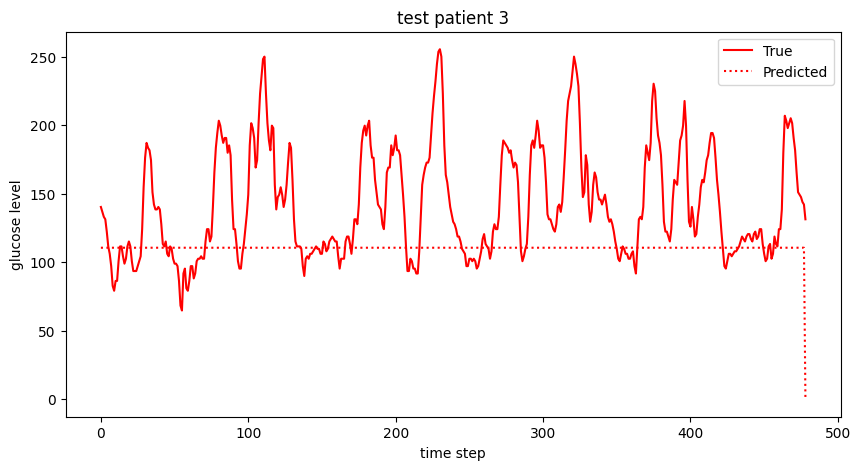

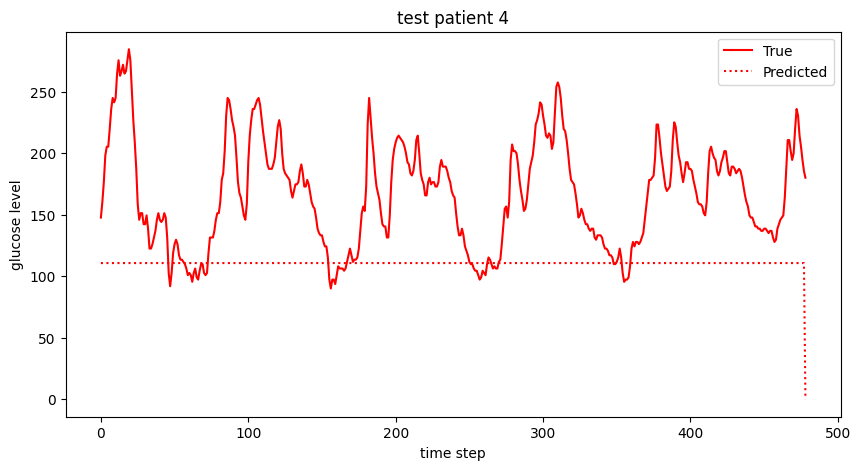

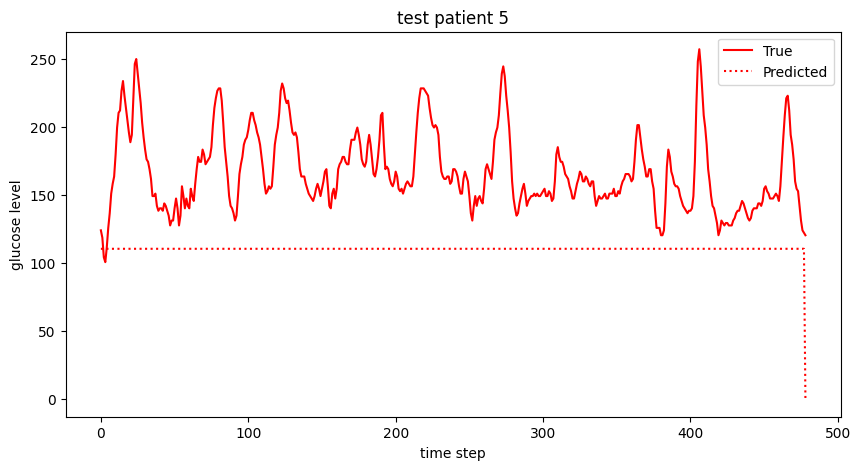

In [80]:
def draw(true, pred, index, color):
    true = true.detach().cpu().numpy()  # Detach the tensor from the computation graph, move it to cpu and convert to numpy array
    pred = pred.detach().cpu().numpy()  # Detach the tensor from the computation graph, move it to cpu and convert to numpy array

    plt.figure(figsize=(10, 5))
    plt.title(f"test patient {index}")
    plt.xlabel("time step")
    plt.ylabel("glucose level")
    n = true.shape[0]
    plt.plot(np.arange(n), true[:, index], color, label="True")
    plt.plot(np.arange(n), pred[:, index], color + ":", label="Predicted")
    plt.legend()
    plt.show()

print(test_target.shape)
print(all_test_outputs.shape)

draw(test_target, all_test_outputs, 0, 'r')
draw(test_target, all_test_outputs, 1, 'r')
draw(test_target, all_test_outputs, 2, 'r')
draw(test_target, all_test_outputs, 3, 'r')
draw(test_target, all_test_outputs, 4, 'r')
draw(test_target, all_test_outputs, 5, 'r')

**Graph 2 Variable Time Horizon**

In [84]:
final_test_losses = []

prediction_horizons = range(1, 9)

for prediction_horizon in prediction_horizons:
  print(f'Prediction Horizon: {prediction_horizon}\n')
  train_input, train_target, test_input, test_target = train_test_split(df, training_patients, prediction_horizon, device)

  # Initialize the model
  model = TransformerModel(d_model=1, nhead=NHEAD, num_layers=NLAYERS, dim_feedforward=NHID).to(device)
  criterion = MeanAbsolutePercentageError().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=LR)

  train_losses = []
  test_losses = []
  avg_test_losses = []
  all_test_outputs = torch.zeros(test_input.shape).to(device)


  for epoch in range(N_EPOCHS):
      model.train()
      for t in range(timestep, train_input.shape[0]):  # Loop over the time steps in each epoch
          optimizer.zero_grad()
          output = model(train_input[:t]).squeeze(-1)
          loss = criterion(output[:, -1], train_target[:t, -timestep].squeeze(-1))
          loss.backward()
          optimizer.step()
      train_losses.append(loss.item())

      if epoch % 10 == 0:
          print(f'At epoch {epoch}, Training Loss {loss.item()}')


      model.eval()
      with torch.no_grad():
          test_losses = []  # Collect test losses at each time step
          for t in range(timestep, test_input.shape[0]):
              test_output = model(test_input[:t]).squeeze(-1)
              all_test_outputs[:t, :] = test_output.unsqueeze(-1)  # Adjust dimensions here
              test_loss = criterion(test_output[:, -1], test_target[:t, -timestep].squeeze(-1))
              test_losses.append(test_loss.item())
          avg_test_loss = np.mean(test_losses)
          avg_test_losses.append(avg_test_loss)

          if epoch % 10 == 0:
            print(f'Test Loss at epoch {epoch} is {avg_test_loss}')
  final_test_losses.append(avg_test_losses[-1])

Prediction Horizon: 1

At epoch 0, Training Loss 0.49171626567840576
Test Loss at epoch 0 is 0.6258145159258504
Prediction Horizon: 2

At epoch 0, Training Loss 0.4866887032985687
Test Loss at epoch 0 is 0.6233035983904353
Prediction Horizon: 3

At epoch 0, Training Loss 0.49646830558776855
Test Loss at epoch 0 is 0.6320688221134058
Prediction Horizon: 4

At epoch 0, Training Loss 0.48873454332351685
Test Loss at epoch 0 is 0.6289887410716006
Prediction Horizon: 5

At epoch 0, Training Loss 0.5098044276237488
Test Loss at epoch 0 is 0.6475189160319823
Prediction Horizon: 6

At epoch 0, Training Loss 0.502765417098999
Test Loss at epoch 0 is 0.6448725363668881
Prediction Horizon: 7

At epoch 0, Training Loss 0.5086228847503662
Test Loss at epoch 0 is 0.6508274229906373
Prediction Horizon: 8

At epoch 0, Training Loss 0.5133010149002075
Test Loss at epoch 0 is 0.6554604533371652


In [85]:
final_test_losses

[0.33098310738739606,
 0.33368311942685824,
 0.3368684519317095,
 0.3406926217675209,
 0.3440687212629346,
 0.34923753353430403,
 0.3528809734635939,
 0.35616995935227463]

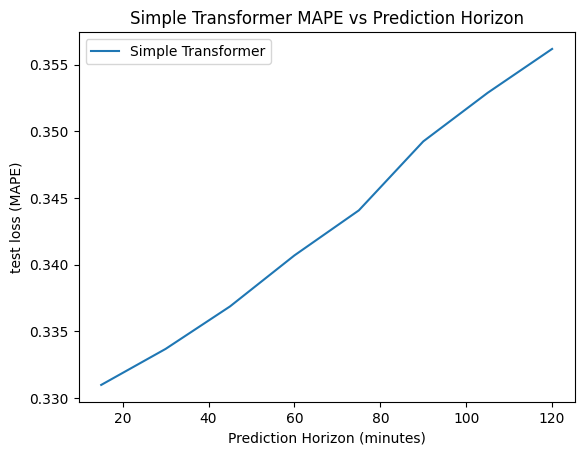

In [86]:
# Training Curve
plt.figure()
plt.plot([15*x for x in prediction_horizons],final_test_losses, label = "Simple Transformer")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Prediction Horizon (minutes)")
plt.title("Simple Transformer MAPE vs Prediction Horizon")
plt.legend()
plt.show()

Graph 3 Variable Training Patients

In [89]:
training_patients_sizes = [1,10,20,30,40,50,60,70,80,90]

final_test_losses = []


for training_patients in training_patients_sizes:
  print(f'Training Patient Size: {training_patients}\n')
  train_input, train_target, test_input, test_target = train_test_split(df, training_patients, prediction_horizon, device)

  # Initialize the model
  model = TransformerModel(d_model=1, nhead=NHEAD, num_layers=NLAYERS, dim_feedforward=NHID).to(device)
  criterion = MeanAbsolutePercentageError().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=LR)

  train_losses = []
  test_losses = []
  avg_test_losses = []
  all_test_outputs = torch.zeros(test_input.shape).to(device)


  for epoch in range(N_EPOCHS):
      model.train()
      for t in range(timestep, train_input.shape[0]):  # Loop over the time steps in each epoch
          optimizer.zero_grad()
          output = model(train_input[:t]).squeeze(-1)
          loss = criterion(output[:, -1], train_target[:t, -timestep].squeeze(-1))
          loss.backward()
          optimizer.step()
      train_losses.append(loss.item())

      if epoch % 10 == 0:
          print(f'At epoch {epoch}, Training Loss {loss.item()}')


      model.eval()
      with torch.no_grad():
          test_losses = []  # Collect test losses at each time step
          for t in range(timestep, test_input.shape[0]):
              test_output = model(test_input[:t]).squeeze(-1)
              all_test_outputs[:t, :] = test_output.unsqueeze(-1)  # Adjust dimensions here
              test_loss = criterion(test_output[:, -1], test_target[:t, -timestep].squeeze(-1))
              test_losses.append(test_loss.item())
          avg_test_loss = np.mean(test_losses)
          avg_test_losses.append(avg_test_loss)

          if epoch % 10 == 0:
            print(f'Test Loss at epoch {epoch} is {avg_test_loss}')
  final_test_losses.append(avg_test_losses[-1])

Training Patient Size: 1

At epoch 0, Training Loss 0.5028061270713806
Test Loss at epoch 0 is 0.6787495929470994
Training Patient Size: 10

At epoch 0, Training Loss 0.5308899879455566
Test Loss at epoch 0 is 0.6594011993671426
Training Patient Size: 20

At epoch 0, Training Loss 0.5097207427024841
Test Loss at epoch 0 is 0.6429427282572299
Training Patient Size: 30

At epoch 0, Training Loss 0.46560126543045044
Test Loss at epoch 0 is 0.6302549952914
Training Patient Size: 40

At epoch 0, Training Loss 0.4134085476398468
Test Loss at epoch 0 is 0.6338289502826213
Training Patient Size: 50

At epoch 0, Training Loss 0.546760618686676
Test Loss at epoch 0 is 0.6429498910650833
Training Patient Size: 60

At epoch 0, Training Loss 0.5809990167617798
Test Loss at epoch 0 is 0.6422896652211556
Training Patient Size: 70

At epoch 0, Training Loss 0.5990908145904541
Test Loss at epoch 0 is 0.6439832193330088
Training Patient Size: 80

At epoch 0, Training Loss 0.5645631551742554
Test Loss at

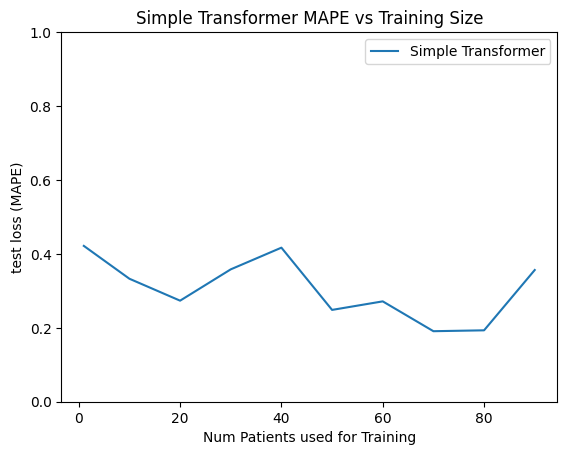

In [90]:
#Training Curve
plt.figure()
plt.plot(training_patients_sizes,final_test_losses, label = "Simple Transformer")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Num Patients used for Training")
plt.title("Simple Transformer MAPE vs Training Size")
plt.ylim(0,1)
plt.legend()
plt.show()